In [1]:
# download pre-trained model
!gdown --id 1Wk9e78TVXMF0aQ4b4c0SovIJoJOMgHL5
!gdown --id 1p7hlZ3sxhbKoZjcACPVTeago1CESLZQ_
!gdown --id 1ZAHzRAnUB8JU0j6kVhgUZ5qA5x53XLo8
!gdown --id 1AmTfWS0SnkPhQT9DxAfCCIZ53z_PbGk7

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Wk9e78TVXMF0aQ4b4c0SovIJoJOMgHL5
From (redirected): https://drive.google.com/uc?id=1Wk9e78TVXMF0aQ4b4c0SovIJoJOMgHL5&confirm=t&uuid=b0abf330-a545-4097-a73c-470a00d891f0
To: /content/Transformer_FAU_fold0.h5
100% 161M/161M [00:03<00:00, 47.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1p7hlZ3sxhbKoZjcACPVTeago1CESLZQ_
From (redirected): https://drive.google.com/uc?id=1p7hlZ3sxhbKoZjcACPVTeago1CESLZQ_&confirm=t&uuid=87edc2bb-a0c1-4a21-8204-9206eff3cc1a
To: /content/Tr

In [2]:
!pip install keras_pos_embd
!pip install keras_multi_head
!pip install keras_layer_normalization
!pip install keras_position_wise_feed_forward
!pip install keras_embed_sim

  Preparing metadata (setup.py) ... done
  Created wheel for keras_pos_embd: filename=keras_pos_embd-0.13.0-py3-none-any.whl size=6945 sha256=384fa9a6d01f9c8096664cf2a457f93d337547db6888693b3f6ad4c7ef7ef9b9
  Stored in directory: /root/.cache/pip/wheels/78/07/1b/b1ca47b6ac338554b75c8f52c54e6a2bfbe1b07d79579979a4
Successfully built keras_pos_embd
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras_multi_head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14976 sha256=aec606796a51e3cfe6a87c9d6bc9acad5b8a21c335e6f4debe8e3d5899ea1598
  Stored in directory: /root/.cache/pip/wheels/cb/23/4b/06d7ae21714f70fcc25b48f972cc8e5e7f4b6b764a038b509d
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=eda0c8e554e50b3cce506a1365ad8b3ec151ecb08f46b22f7c3d30dba02104a0
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Succes

In [3]:
import cv2
im = cv2.imread('face1.png')
import numpy as np

In [4]:
im = np.expand_dims(cv2.resize(im, dsize=(224,224)),axis=0)
print(im.shape)

AU_count =12

mapping_BP4D = {0:'Inner Brow Raiser',1:'Outer Brow Raiser',2:'Brow Lowerer',
                3:'Cheek raiser',4:'Lid Tightener',
                5:'Upper Lip Raiser',6:'Lip Corner Puller',
                7:'Dimpler',8:'Lip Corner Depressor',9:'Chin Raiser',
                10:'Lip Tightener',11:'Lip pressor'}

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
import logging
logging.getLogger('tensorflow').disabled = True
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras_pos_embd import TrigPosEmbedding,PositionEmbedding
from keras_multi_head import MultiHeadAttention


(1, 224, 224, 3)


Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import numpy as np
from tensorflow.keras.layers import Input, Activation, Conv2D,Conv2DTranspose, Flatten, Dense, MaxPooling2D,Multiply,AveragePooling2D, UpSampling2D,BatchNormalization,concatenate,Concatenate,ZeroPadding2D, GlobalAveragePooling2D, Dropout, Add
from tensorflow.keras.layers import dot, Reshape,RepeatVector, multiply,Lambda,add,Permute
from tensorflow.keras import backend as K
from keras_layer_normalization import LayerNormalization
from keras_multi_head import MultiHeadAttention
from keras_position_wise_feed_forward import FeedForward
from keras_pos_embd import TrigPosEmbedding
from keras_embed_sim import EmbeddingRet, EmbeddingSim
# from .backend import keras


In [6]:
import math

def gelu(x):
    """An approximation of gelu.
    See: https://arxiv.org/pdf/1606.08415.pdf
    """
    return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x * x * x)))



def get_custom_objects():
    return {
        'gelu': gelu,
        'LayerNormalization': LayerNormalization,
        'MultiHeadAttention': MultiHeadAttention,
        'FeedForward': FeedForward,
        'TrigPosEmbedding': TrigPosEmbedding,
        'EmbeddingRet': EmbeddingRet,
        'EmbeddingSim': EmbeddingSim,
    }


def _wrap_layer(name,
                input_layer,
                build_func,
                dropout_rate=0.0,
                trainable=True):
    """Wrap layers with residual, normalization and dropout.
    :param name: Prefix of names for internal layers.
    :param input_layer: Input layer.
    :param build_func: A callable that takes the input tensor and generates the output tensor.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    build_output = build_func(input_layer)
    if dropout_rate > 0.0:
        dropout_layer = Dropout(
            rate=dropout_rate,
            name='%s-Dropout' % name,
        )(build_output)
    else:
        dropout_layer = build_output
    if isinstance(input_layer, list):
        input_layer = input_layer[0]
    add_layer = Add(name='%s-Add' % name)([input_layer, dropout_layer])
    normal_layer = LayerNormalization(
        trainable=trainable,
        name='%s-Norm' % name,
    )(add_layer)
    return normal_layer



def attention_builder(name,
                      head_num,
                      activation,
                      history_only,
                      trainable=True):
    """Get multi-head self-attention builder.
    :param name: Prefix of names for internal layers.
    :param head_num: Number of heads in multi-head self-attention.
    :param activation: Activation for multi-head self-attention.
    :param history_only: Only use history data.
    :param trainable: Whether the layer is trainable.
    :return:
    """
    def _attention_builder(x):
        return MultiHeadAttention(
            head_num=head_num,
            activation=activation,
            history_only=history_only,
            trainable=trainable,
            name=name,
        )(x)
    return _attention_builder


def feed_forward_builder(name,
                         hidden_dim,
                         activation,
                         trainable=True):
    """Get position-wise feed-forward layer builder.
    :param name: Prefix of names for internal layers.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param activation: Activation for feed-forward layer.
    :param trainable: Whether the layer is trainable.
    :return:
    """
    def _feed_forward_builder(x):
        return FeedForward(
            units=hidden_dim,
            activation=activation,
            trainable=trainable,
            name=name,
        )(x)
    return _feed_forward_builder


def get_encoder_component(name,
                          input_layer,
                          head_num,
                          hidden_dim,
                          attention_activation=None,
                          feed_forward_activation=gelu,
                          dropout_rate=0.0,
                          trainable=True,):
    """Multi-head self-attention and feed-forward layer.
    :param name: Prefix of names for internal layers.
    :param input_layer: Input layer.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    attention_name = '%s-MultiHeadSelfAttention' % name
    feed_forward_name = '%s-FeedForward' % name
    attention_layer = _wrap_layer(
        name=attention_name,
        input_layer=input_layer,
        build_func=attention_builder(
            name=attention_name,
            head_num=head_num,
            activation=attention_activation,
            history_only=False,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )
    feed_forward_layer = _wrap_layer(
        name=feed_forward_name,
        input_layer=attention_layer,
        build_func=feed_forward_builder(
            name=feed_forward_name,
            hidden_dim=hidden_dim,
            activation=feed_forward_activation,
            trainable=trainable,
        ),
        dropout_rate=dropout_rate,
        trainable=trainable,
    )

    return feed_forward_layer




def get_encoders(name,encoder_num,
                 input_layer,
                 head_num,
                 hidden_dim,
                 attention_activation=None,
                 feed_forward_activation=gelu,
                 dropout_rate=0.0,
                 trainable=True):
    """Get encoders.
    :param encoder_num: Number of encoder components.
    :param input_layer: Input layer.
    :param head_num: Number of heads in multi-head self-attention.
    :param hidden_dim: Hidden dimension of feed forward layer.
    :param attention_activation: Activation for multi-head self-attention.
    :param feed_forward_activation: Activation for feed-forward layer.
    :param dropout_rate: Dropout rate.
    :param trainable: Whether the layers are trainable.
    :return: Output layer.
    """
    last_layer = input_layer
    for i in range(encoder_num):
        last_layer = get_encoder_component(
            name='%sEncoder-%d' % (name,i + 1),
            input_layer=last_layer,
            head_num=head_num,
            hidden_dim=hidden_dim,
            attention_activation=attention_activation,
            feed_forward_activation=feed_forward_activation,
            dropout_rate=dropout_rate,
            trainable=trainable,
        )
    return last_layer




In [7]:
base_model = InceptionV3(weights="imagenet",
                         include_top=False, input_shape= (224,224,3))
base_model = Model(inputs=base_model.input,
                   outputs = base_model.get_layer('activation_74').output)


87910968/87910968 [==============================] - 2s 0us/step


In [8]:
def baseline_model(AU_count):
    fc_dim = 256
    # create model
    inputs = Input(shape=(224,224,3))

    #block 1
    g = base_model(inputs)

    gh = Conv2D(64, (3,3), padding='same',
                kernel_initializer='glorot_normal')(g)
    gh1 = Conv2D(AU_count, (1,1), padding='same',
                 kernel_initializer='glorot_normal')(gh)
    gh2 = Conv2D(AU_count, (1,1), padding='same',
                 activation='sigmoid',name = "att_loss",
                 kernel_initializer='glorot_normal')(gh1)
    gh1 = Conv2D(AU_count, (1,1), padding='same',
                 activation='linear',
                 kernel_initializer='glorot_normal')(gh1)
    gap = GlobalAveragePooling2D()(gh1)
    att_output = Activation('sigmoid',name="att_outputs")(gap)
    attention = gh2
    reshape_embed = Reshape([12*12,AU_count])(attention)
    reshape_embed = Permute((2,1))(reshape_embed)

    for i in range(AU_count):

        layer1 = Lambda(lambda x: K.expand_dims(attention[...,i],axis=-1))(attention)

        out = Multiply()([layer1,g])
        g = Add()([out,g])
        mt = Conv2D(64, (1,1), padding='same',
                    kernel_initializer='glorot_normal')(g)
        mt = MaxPooling2D(pool_size=7,
                          strides=(1,1),padding = 'same')(mt)
        mt = BatchNormalization()(mt)
        mt = Activation('relu')(mt)
        perception = Flatten()(mt)

        inter = Dense(fc_dim, activation='relu',
                      kernel_initializer='glorot_normal')(perception)
        tin = Lambda(lambda x: K.expand_dims(x,axis=1))(inter)

        if i==0:
            feat_outputs = tin
        else:
            feat_outputs= Concatenate(axis = 1,
                                      name = 'feat_outputs_{}'.format(i+1))([feat_outputs,tin])

    feat_outputs_P  = PositionEmbedding(
        input_shape=(None,),
        input_dim = AU_count,
        output_dim = fc_dim,
        mask_zero=0,  # The index that presents padding (because `0` will be used in relative positioning).
        mode=PositionEmbedding.MODE_ADD,)(feat_outputs)
    feat_outputs_P = get_encoders(name = '1',encoder_num=3,
                                  input_layer=feat_outputs_P,
                                  head_num=8,hidden_dim=fc_dim,
                                  dropout_rate=0.1,)




    feat_outputs_P = Flatten()(feat_outputs_P)
    inter = Dense(fc_dim, activation='relu',
                  kernel_initializer='glorot_normal')(feat_outputs_P)
    final = Dense(AU_count, activation='sigmoid',
                  name = 'per_outputs_{}'.format(i+1),
                  kernel_initializer='glorot_normal')(inter)
    model = Model(inputs=inputs,
                  outputs=[att_output,final,gh2,feat_outputs])#;model.summary()

    return model


model=baseline_model(AU_count)
model.load_weights('Transformer_FAU_fold2.h5')
y_predict = model.predict(im)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [9]:
!kaggle datasets download -d rahulk2197/frames-10fps

Dataset URL: https://www.kaggle.com/datasets/rahulk2197/frames-10fps
License(s): unknown
 99% 393M/395M [00:04<00:00, 126MB/s] 
100% 395M/395M [00:04<00:00, 99.3MB/s]


In [10]:
!kaggle datasets download -d rahulk2197/labels-csv

Dataset URL: https://www.kaggle.com/datasets/rahulk2197/labels-csv
License(s): unknown
  0% 0.00/37.6k [00:00<?, ?B/s]
100% 37.6k/37.6k [00:00<00:00, 16.1MB/s]


In [11]:
!unzip frames-10fps.zip

Streaming output truncated to the last 5000 lines.
  inflating: frames/RightVideoSN030/720.jpg  
  inflating: frames/RightVideoSN030/722.jpg  
  inflating: frames/RightVideoSN030/724.jpg  
  inflating: frames/RightVideoSN030/726.jpg  
  inflating: frames/RightVideoSN030/728.jpg  
  inflating: frames/RightVideoSN030/730.jpg  
  inflating: frames/RightVideoSN030/732.jpg  
  inflating: frames/RightVideoSN030/734.jpg  
  inflating: frames/RightVideoSN030/736.jpg  
  inflating: frames/RightVideoSN030/738.jpg  
  inflating: frames/RightVideoSN030/74.jpg  
  inflating: frames/RightVideoSN030/740.jpg  
  inflating: frames/RightVideoSN030/742.jpg  
  inflating: frames/RightVideoSN030/744.jpg  
  inflating: frames/RightVideoSN030/746.jpg  
  inflating: frames/RightVideoSN030/748.jpg  
  inflating: frames/RightVideoSN030/750.jpg  
  inflating: frames/RightVideoSN030/752.jpg  
  inflating: frames/RightVideoSN030/754.jpg  
  inflating: frames/RightVideoSN030/756.jpg  
  inflating: frames/RightVideo

In [12]:
!unzip labels-csv.zip

Archive:  labels-csv.zip
  inflating: labels_csv/RightVideoSN001.csv  
  inflating: labels_csv/RightVideoSN002.csv  
  inflating: labels_csv/RightVideoSN003.csv  
  inflating: labels_csv/RightVideoSN004.csv  
  inflating: labels_csv/RightVideoSN005.csv  
  inflating: labels_csv/RightVideoSN006.csv  
  inflating: labels_csv/RightVideoSN007.csv  
  inflating: labels_csv/RightVideoSN008.csv  
  inflating: labels_csv/RightVideoSN009.csv  
  inflating: labels_csv/RightVideoSN010.csv  
  inflating: labels_csv/RightVideoSN011.csv  
  inflating: labels_csv/RightVideoSN012.csv  
  inflating: labels_csv/RightVideoSN013.csv  
  inflating: labels_csv/RightVideoSN016.csv  
  inflating: labels_csv/RightVideoSN017.csv  
  inflating: labels_csv/RightVideoSN018.csv  
  inflating: labels_csv/RightVideoSN021.csv  
  inflating: labels_csv/RightVideoSN023.csv  
  inflating: labels_csv/RightVideoSN024.csv  
  inflating: labels_csv/RightVideoSN025.csv  
  inflating: labels_csv/RightVideoSN026.csv  
  inflati

In [13]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [14]:
folder_path = '/content/frames'  # Replace with your folder path
folders=sorted(os.listdir(folder_path))

In [15]:
paths=[]
for i in tqdm(range(len(folders))):
    files=os.listdir(os.path.join(folder_path,folders[i]))
    files.sort(key=lambda x: int(x.split('.')[0]))
    files=[os.path.join(folder_path,folders[i],files[j]) for j in range(len(files))]
    paths=paths+files

100%|██████████| 27/27 [00:00<00:00, 187.85it/s]


In [16]:
def get_csv_id(file_path):

    # Extract the filename without extension
    filename = os.path.basename(file_path)  # RightVideoSN001.csv

    # Extract the identifier ('1' or '11')
    if filename.startswith('RightVideoSN'):
        identifier = filename[len('RightVideoSN'):]  # Get '001' or '011'
        identifier = identifier.lstrip('0').split('.')[0]  # Remove leading zeros

    return int(identifier)
def get_id(path):

    # Split the path by '/'
    parts = path.split('/')

    # Get the directory name that contains the image
    dirname = parts[-2]  # RightVideoSN011

    # Extract the relevant parts from the directory name
    if dirname.startswith('RightVideoSN'):
        identifier = dirname[len('RightVideoSN'):]  # Get SN011 -> 011
        identifier = identifier.lstrip('0')  # Remove leading zeros

    # Get the image number from the filename
    filename = parts[-1]  # 240.jpg
    image_number = os.path.splitext(filename)[0]  # 240

    return int(identifier),int(image_number)

In [17]:
get_id(paths[0])

(1, 0)

In [18]:
folder_path = '/content/labels_csv'
csv_path=[]
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        csv_path.append(file_path)
csv_path=sorted(csv_path)
csv={}
for file in csv_path:
    df=pd.read_csv(file)
    ide=get_csv_id(file)
    csv[ide]=df

In [19]:
labels=[]
for file in tqdm(paths):
    ide,image=get_id(file)
    try:
        label=np.array(csv[ide].iloc[image])
        label[label > 0]=1
        labels.append(label)
    except IndexError as e:
        print(f"IndexError occurred: {ide}")
        print(f"Check ide={ide} and image={image} against csv indices.")
labels=np.array(labels)

100%|██████████| 65420/65420 [00:03<00:00, 21529.02it/s]


In [32]:
frames=[]
target_size=(224, 224)
for i in tqdm(range(len(paths))):
    img=cv2.imread(paths[i],0)
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    rgb_image = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
    frames.append(rgb_image)

100%|██████████| 65420/65420 [00:16<00:00, 3872.45it/s]


In [33]:
frames[0].shape

(224, 224, 3)

In [ ]:
pred=[]
for image in tqdm(frames):
    im = np.expand_dims(cv2.resize(image, dsize=(224,224)),axis=0)
    pred.append(model.predict(im)[0][0])

  0%|          | 229/65420 [00:11<54:18, 20.01it/s]

In [23]:
pred=np.array(pred).astype(int)

In [28]:
real=labels


In [29]:
col=csv[1].columns
au = csv[1].columns


In [30]:
pred[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

Accuracy of each action unit 
au1   :  0.9324
au12   :  0.77535
au15   :  0.9761
au17   :  0.6055
au2   :  0.938
au20   :  0.95335
au25   :  0.26205
au26   :  0.8263
au4   :  0.8324
au5   :  0.9924
au6   :  0.7992
au9   :  0.9214


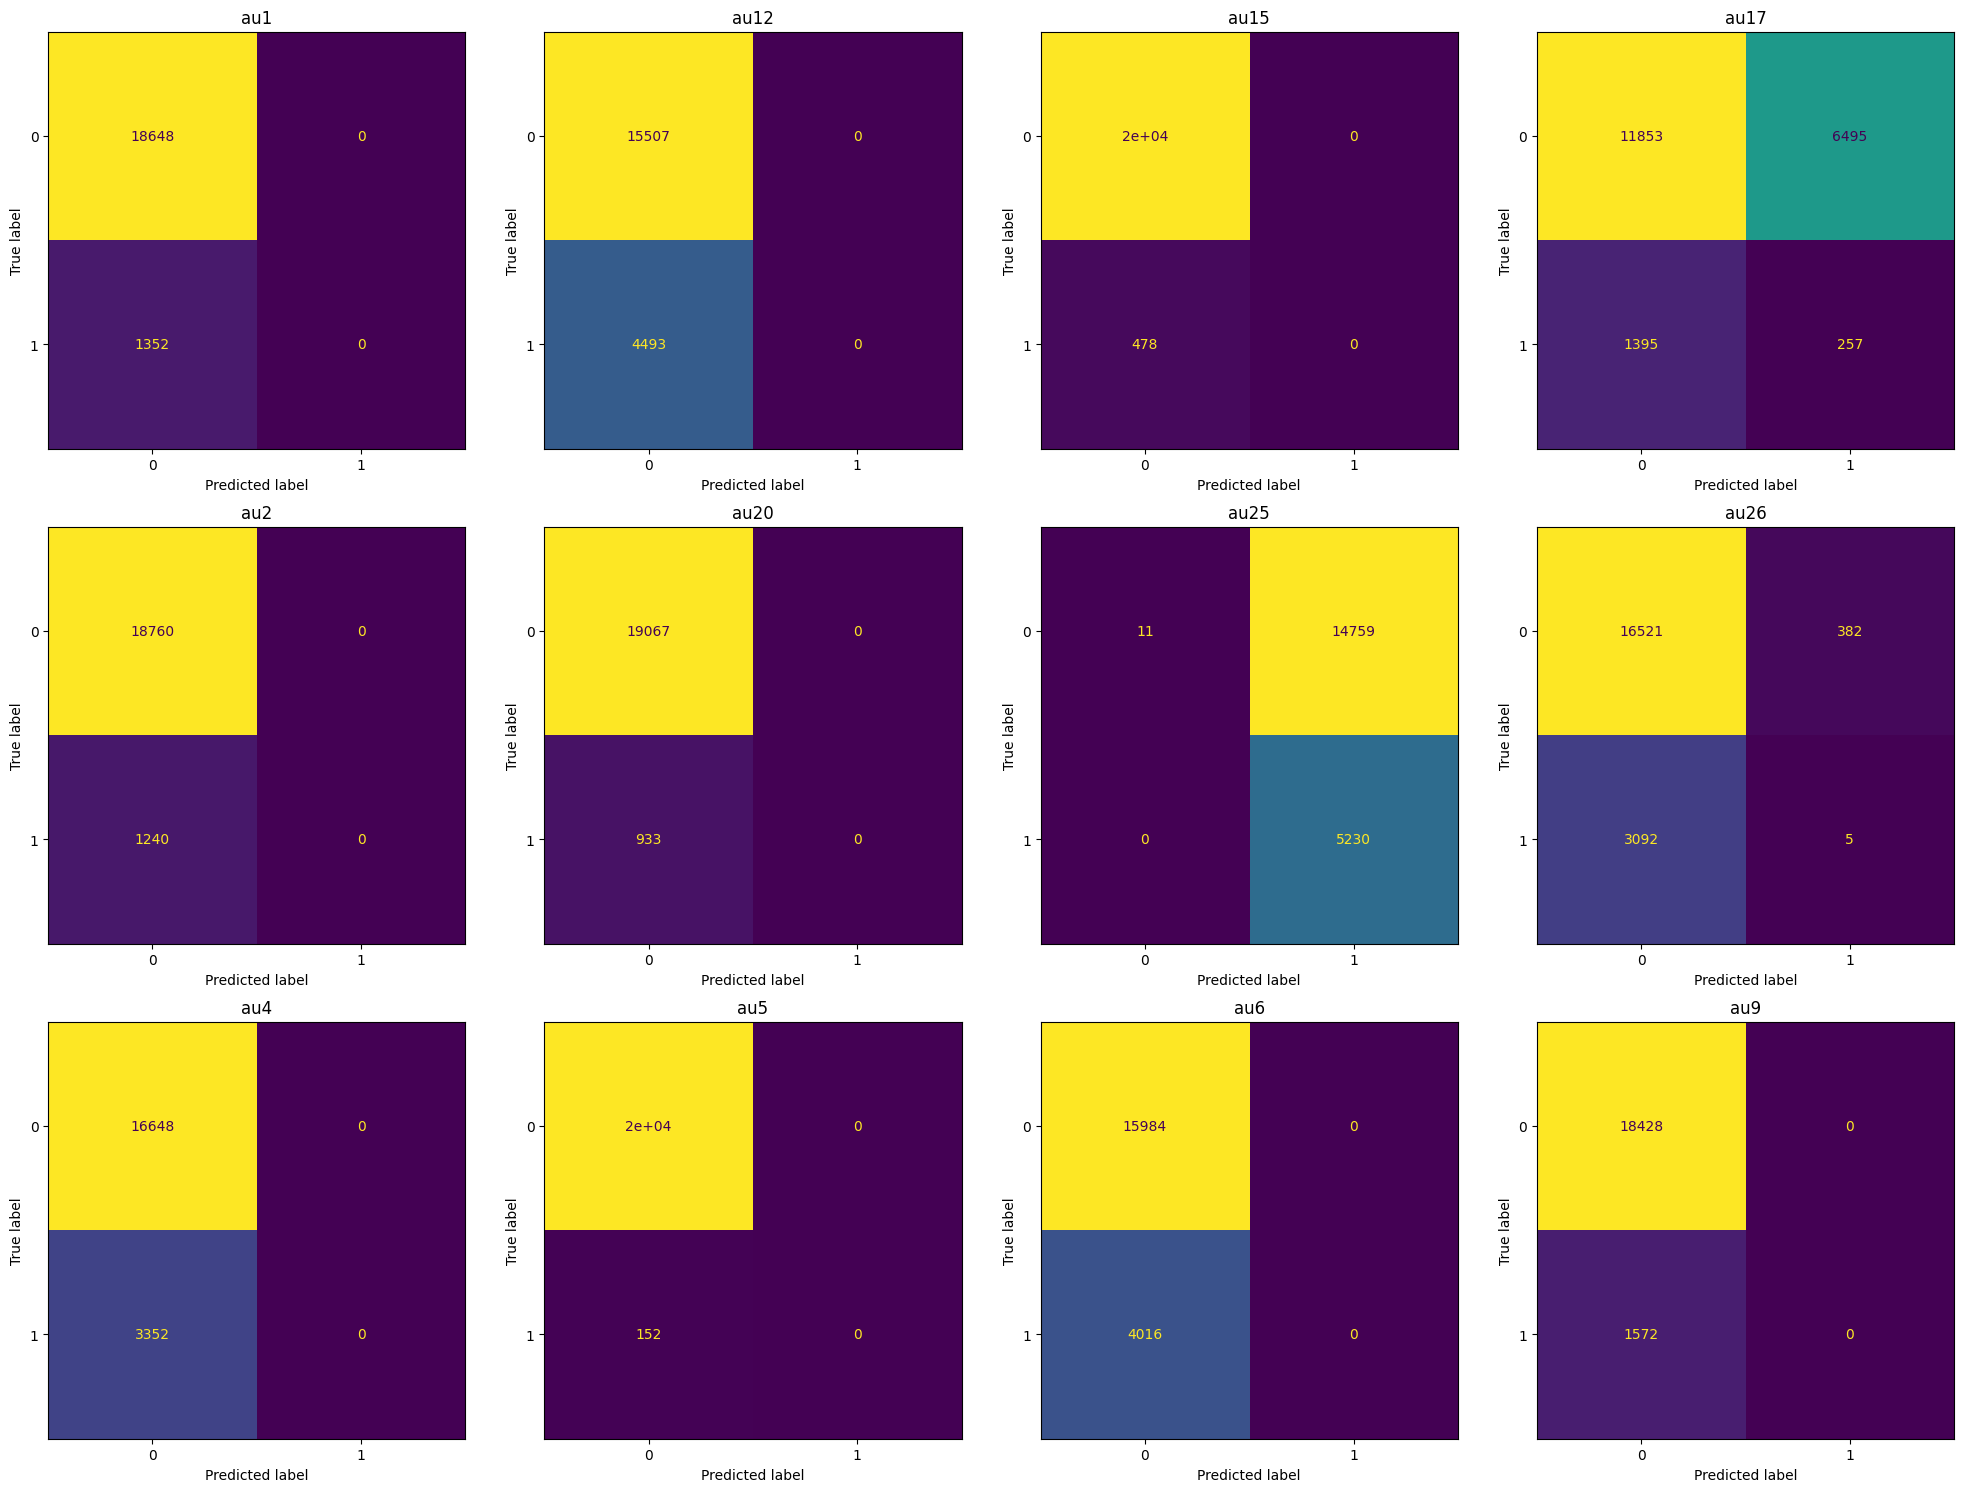

In [31]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
print("Accuracy of each action unit ")

for i in range(12):
    print(f'{au[i] }   : ', accuracy_score(real[:, i], pred[:, i]))
for i in range(12):
    cm = confusion_matrix(real[:, i], pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()